## 1. Setup and Data Loading

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings

warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('Set2')

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


In [2]:
# Load datasets
print("Loading datasets...")

train_transaction = pd.read_csv('../data/train_transaction.csv')
train_identity = pd.read_csv('../data/train_identity.csv')
test_transaction = pd.read_csv('../data/test_transaction.csv')

print(f"✓ Data loaded successfully")
print(f"  Train shape: {train_transaction.shape}")
print(f"  Test shape: {test_transaction.shape}")

Loading datasets...
✓ Data loaded successfully
  Train shape: (590540, 394)
  Test shape: (506691, 393)
✓ Data loaded successfully
  Train shape: (590540, 394)
  Test shape: (506691, 393)


## 2. Understanding TransactionDT

In [3]:
# Analyze TransactionDT column
print("="*60)
print("TRANSACTION DATETIME ANALYSIS")
print("="*60)

print("\nTransactionDT is a timedelta in seconds from a reference point.")
print("It represents when the transaction occurred.\n")

print("Train Transaction DT Statistics:")
print(train_transaction['TransactionDT'].describe())

print("\nTest Transaction DT Statistics:")
print(test_transaction['TransactionDT'].describe())

print(f"\nTime range:")
train_range = train_transaction['TransactionDT'].max() - train_transaction['TransactionDT'].min()
test_range = test_transaction['TransactionDT'].max() - test_transaction['TransactionDT'].min()

print(f"  Train: {train_range:,.0f} seconds ({train_range/86400:.1f} days)")
print(f"  Test:  {test_range:,.0f} seconds ({test_range/86400:.1f} days)")

# Check for overlap
train_end = train_transaction['TransactionDT'].max()
test_start = test_transaction['TransactionDT'].min()
print(f"\n  Train ends at: {train_end:,.0f}")
print(f"  Test starts at: {test_start:,.0f}")
print(f"  Gap: {test_start - train_end:,.0f} seconds ({(test_start - train_end)/86400:.1f} days)")
print(f"\n  ✓ Train and test are chronologically separated (no leakage)")

TRANSACTION DATETIME ANALYSIS

TransactionDT is a timedelta in seconds from a reference point.
It represents when the transaction occurred.

Train Transaction DT Statistics:
count    5.905400e+05
mean     7.372311e+06
std      4.617224e+06
min      8.640000e+04
25%      3.027058e+06
50%      7.306528e+06
75%      1.124662e+07
max      1.581113e+07
Name: TransactionDT, dtype: float64

Test Transaction DT Statistics:
count    5.066910e+05
mean     2.692994e+07
std      4.756507e+06
min      1.840322e+07
25%      2.277154e+07
50%      2.720466e+07
75%      3.134856e+07
max      3.421434e+07
Name: TransactionDT, dtype: float64

Time range:
  Train: 15,724,731 seconds (182.0 days)
  Test:  15,811,121 seconds (183.0 days)

  Train ends at: 15,811,131
  Test starts at: 18,403,224
  Gap: 2,592,093 seconds (30.0 days)

  ✓ Train and test are chronologically separated (no leakage)


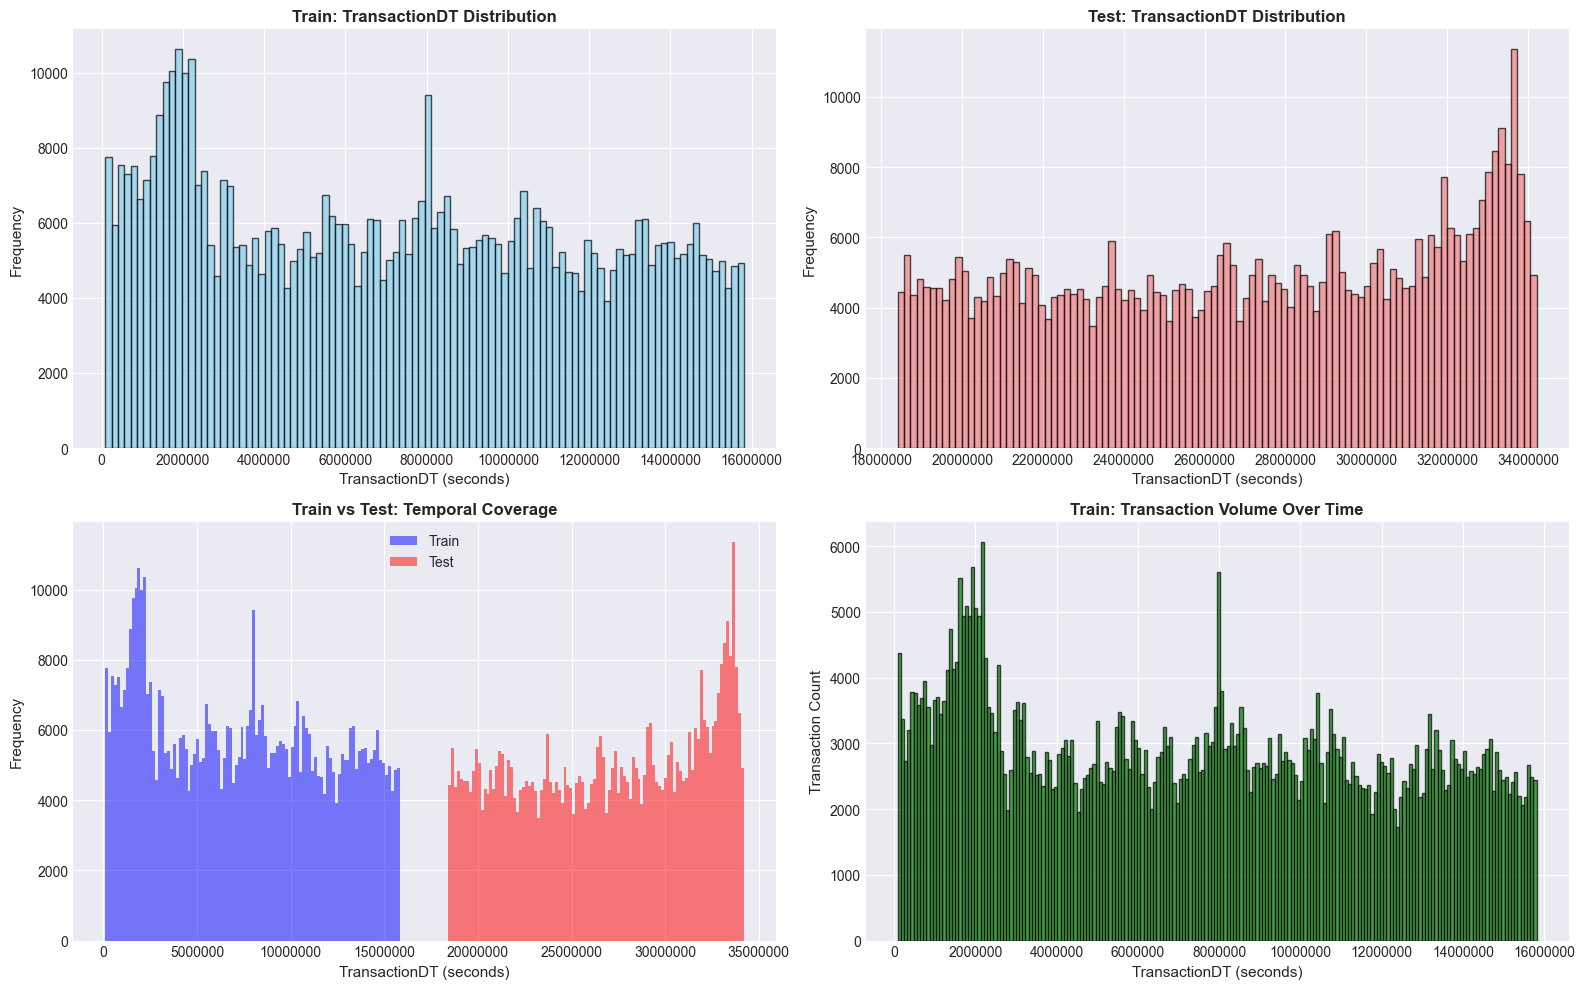

Note: Train and test datasets are temporally sequential (test comes after train)


In [4]:
# Visualize TransactionDT distribution
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Train distribution
ax1 = axes[0, 0]
ax1.hist(train_transaction['TransactionDT'], bins=100, color='skyblue', edgecolor='black', alpha=0.7)
ax1.set_xlabel('TransactionDT (seconds)', fontsize=11)
ax1.set_ylabel('Frequency', fontsize=11)
ax1.set_title('Train: TransactionDT Distribution', fontsize=12, fontweight='bold')
ax1.ticklabel_format(style='plain', axis='x')

# Test distribution
ax2 = axes[0, 1]
ax2.hist(test_transaction['TransactionDT'], bins=100, color='lightcoral', edgecolor='black', alpha=0.7)
ax2.set_xlabel('TransactionDT (seconds)', fontsize=11)
ax2.set_ylabel('Frequency', fontsize=11)
ax2.set_title('Test: TransactionDT Distribution', fontsize=12, fontweight='bold')
ax2.ticklabel_format(style='plain', axis='x')

# Combined view
ax3 = axes[1, 0]
ax3.hist(train_transaction['TransactionDT'], bins=100, alpha=0.5, label='Train', color='blue')
ax3.hist(test_transaction['TransactionDT'], bins=100, alpha=0.5, label='Test', color='red')
ax3.set_xlabel('TransactionDT (seconds)', fontsize=11)
ax3.set_ylabel('Frequency', fontsize=11)
ax3.set_title('Train vs Test: Temporal Coverage', fontsize=12, fontweight='bold')
ax3.legend(fontsize=10)
ax3.ticklabel_format(style='plain', axis='x')

# Transaction volume over time (train only)
ax4 = axes[1, 1]
time_bins = 200
counts, bins, _ = ax4.hist(train_transaction['TransactionDT'], bins=time_bins, 
                            color='green', edgecolor='black', alpha=0.7)
ax4.set_xlabel('TransactionDT (seconds)', fontsize=11)
ax4.set_ylabel('Transaction Count', fontsize=11)
ax4.set_title('Train: Transaction Volume Over Time', fontsize=12, fontweight='bold')
ax4.ticklabel_format(style='plain', axis='x')

plt.tight_layout()
plt.show()

print("Note: Train and test datasets are temporally sequential (test comes after train)")

## 3. Creating Time-Based Features

In [5]:
# Create time-based features
def create_time_features(df):
    """
    Create time-based features from TransactionDT.
    Since we don't have the reference date, we'll work with relative time periods.
    """
    df = df.copy()
    
    # Seconds in a day and week
    SECONDS_IN_DAY = 86400
    SECONDS_IN_WEEK = 604800
    
    # Day of week (0-6) - assuming week starts from first transaction
    df['DT_day_of_week'] = ((df['TransactionDT'] / SECONDS_IN_DAY) % 7).astype(int)
    
    # Hour of day (0-23)
    df['DT_hour'] = ((df['TransactionDT'] % SECONDS_IN_DAY) / 3600).astype(int)
    
    # Day since start
    df['DT_day'] = (df['TransactionDT'] / SECONDS_IN_DAY).astype(int)
    
    # Week since start
    df['DT_week'] = (df['TransactionDT'] / SECONDS_IN_WEEK).astype(int)
    
    # Part of day
    df['DT_day_part'] = pd.cut(df['DT_hour'], 
                                bins=[0, 6, 12, 18, 24],
                                labels=['Night', 'Morning', 'Afternoon', 'Evening'],
                                include_lowest=True)
    
    return df

# Apply to train data
train_with_time = create_time_features(train_transaction)

print("✓ Time-based features created:")
print("  - DT_day_of_week: Day of week (0-6)")
print("  - DT_hour: Hour of day (0-23)")
print("  - DT_day: Days since start")
print("  - DT_week: Weeks since start")
print("  - DT_day_part: Part of day (Night/Morning/Afternoon/Evening)")

print("\nSample of new features:")
print(train_with_time[['TransactionDT', 'DT_day_of_week', 'DT_hour', 'DT_day', 'DT_week', 'DT_day_part']].head(10))

✓ Time-based features created:
  - DT_day_of_week: Day of week (0-6)
  - DT_hour: Hour of day (0-23)
  - DT_day: Days since start
  - DT_week: Weeks since start
  - DT_day_part: Part of day (Night/Morning/Afternoon/Evening)

Sample of new features:
   TransactionDT  DT_day_of_week  DT_hour  DT_day  DT_week DT_day_part
0          86400               1        0       1        0       Night
1          86401               1        0       1        0       Night
2          86469               1        0       1        0       Night
3          86499               1        0       1        0       Night
4          86506               1        0       1        0       Night
5          86510               1        0       1        0       Night
6          86522               1        0       1        0       Night
7          86529               1        0       1        0       Night
8          86535               1        0       1        0       Night
9          86536               1        0

## 4. Fraud Rate Over Time

In [6]:
# Analyze fraud rate over time
print("="*60)
print("FRAUD RATE OVER TIME ANALYSIS")
print("="*60)

# By week
fraud_by_week = train_with_time.groupby('DT_week').agg({
    'isFraud': ['sum', 'count', 'mean']
}).reset_index()
fraud_by_week.columns = ['Week', 'Fraud_Count', 'Total_Count', 'Fraud_Rate']
fraud_by_week['Fraud_Rate'] = fraud_by_week['Fraud_Rate'] * 100

print("\nFraud rate by week:")
print(fraud_by_week.head(10))

print(f"\nOverall fraud rate: {train_with_time['isFraud'].mean()*100:.2f}%")
print(f"Min weekly fraud rate: {fraud_by_week['Fraud_Rate'].min():.2f}%")
print(f"Max weekly fraud rate: {fraud_by_week['Fraud_Rate'].max():.2f}%")
print(f"Std of weekly fraud rate: {fraud_by_week['Fraud_Rate'].std():.2f}%")

FRAUD RATE OVER TIME ANALYSIS

Fraud rate by week:
   Week  Fraud_Count  Total_Count  Fraud_Rate
0     0          668        23810    2.805544
1     1          727        27803    2.614826
2     2          879        34470    2.550044
3     3          690        37251    1.852299
4     4          919        24041    3.822636
5     5          838        21868    3.832083
6     6          787        20392    3.859357
7     7          825        20025    4.119850
8     8          922        20246    4.553986
9     9         1014        23596    4.297339

Overall fraud rate: 3.50%
Min weekly fraud rate: 1.85%
Max weekly fraud rate: 5.06%
Std of weekly fraud rate: 0.70%


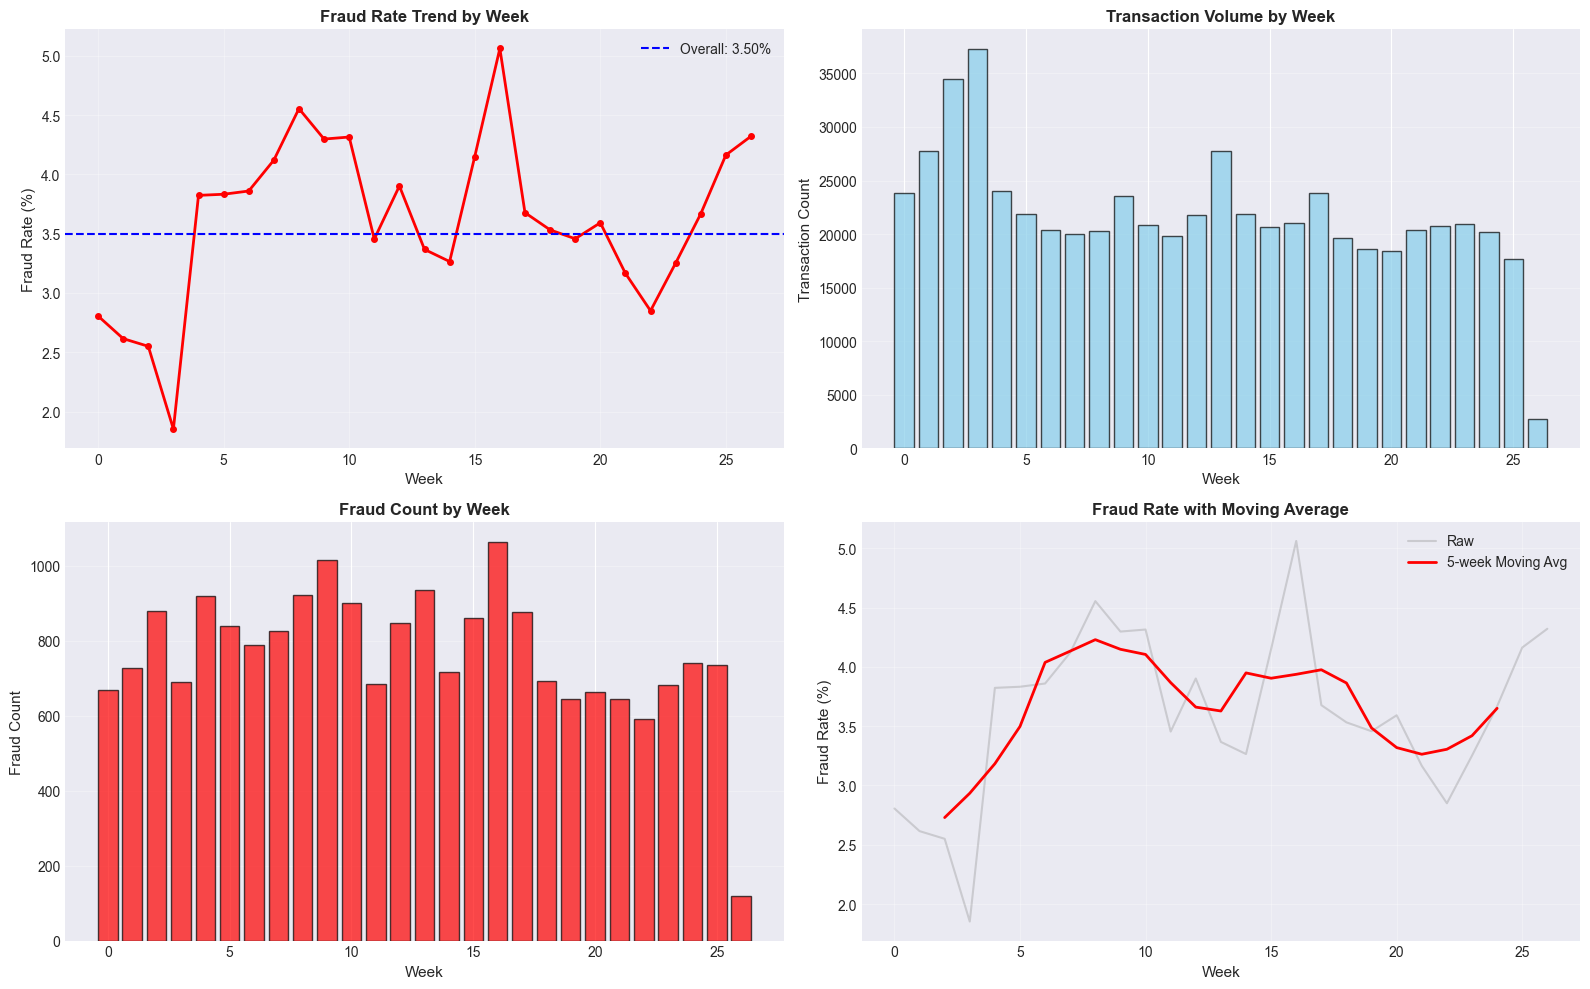


⚠️  Important: Fraud rate varies over time - time-based CV is essential!


In [7]:
# Visualize fraud rate trends
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Fraud rate by week
ax1 = axes[0, 0]
ax1.plot(fraud_by_week['Week'], fraud_by_week['Fraud_Rate'], 
         marker='o', linewidth=2, markersize=4, color='red')
ax1.axhline(y=train_with_time['isFraud'].mean()*100, color='blue', 
            linestyle='--', label=f"Overall: {train_with_time['isFraud'].mean()*100:.2f}%")
ax1.set_xlabel('Week', fontsize=11)
ax1.set_ylabel('Fraud Rate (%)', fontsize=11)
ax1.set_title('Fraud Rate Trend by Week', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Transaction volume by week
ax2 = axes[0, 1]
ax2.bar(fraud_by_week['Week'], fraud_by_week['Total_Count'], 
        color='skyblue', edgecolor='black', alpha=0.7)
ax2.set_xlabel('Week', fontsize=11)
ax2.set_ylabel('Transaction Count', fontsize=11)
ax2.set_title('Transaction Volume by Week', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# Fraud count by week
ax3 = axes[1, 0]
ax3.bar(fraud_by_week['Week'], fraud_by_week['Fraud_Count'], 
        color='red', edgecolor='black', alpha=0.7)
ax3.set_xlabel('Week', fontsize=11)
ax3.set_ylabel('Fraud Count', fontsize=11)
ax3.set_title('Fraud Count by Week', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')

# Rolling average fraud rate
ax4 = axes[1, 1]
window = 5
fraud_by_week['Fraud_Rate_MA'] = fraud_by_week['Fraud_Rate'].rolling(window=window, center=True).mean()
ax4.plot(fraud_by_week['Week'], fraud_by_week['Fraud_Rate'], 
         alpha=0.3, color='gray', label='Raw')
ax4.plot(fraud_by_week['Week'], fraud_by_week['Fraud_Rate_MA'], 
         linewidth=2, color='red', label=f'{window}-week Moving Avg')
ax4.set_xlabel('Week', fontsize=11)
ax4.set_ylabel('Fraud Rate (%)', fontsize=11)
ax4.set_title('Fraud Rate with Moving Average', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n⚠️  Important: Fraud rate varies over time - time-based CV is essential!")

## 5. Hourly and Daily Patterns

In [8]:
# Analyze fraud rate by hour of day
fraud_by_hour = train_with_time.groupby('DT_hour').agg({
    'isFraud': ['sum', 'count', 'mean']
}).reset_index()
fraud_by_hour.columns = ['Hour', 'Fraud_Count', 'Total_Count', 'Fraud_Rate']
fraud_by_hour['Fraud_Rate'] = fraud_by_hour['Fraud_Rate'] * 100

print("="*60)
print("HOURLY PATTERNS")
print("="*60)
print("\nFraud rate by hour of day:")
print(fraud_by_hour.to_string(index=False))

print(f"\nPeak fraud hour: {fraud_by_hour.loc[fraud_by_hour['Fraud_Rate'].idxmax(), 'Hour']:.0f}:00 ({fraud_by_hour['Fraud_Rate'].max():.2f}%)")
print(f"Lowest fraud hour: {fraud_by_hour.loc[fraud_by_hour['Fraud_Rate'].idxmin(), 'Hour']:.0f}:00 ({fraud_by_hour['Fraud_Rate'].min():.2f}%)")

HOURLY PATTERNS

Fraud rate by hour of day:
 Hour  Fraud_Count  Total_Count  Fraud_Rate
    0         1186        37795    3.137981
    1         1027        32797    3.131384
    2         1002        26732    3.748317
    3          797        20802    3.831362
    4          770        14839    5.189029
    5          682         9701    7.030203
    6          467         6007    7.774263
    7          393         3704   10.610151
    8          241         2591    9.301428
    9          223         2479    8.995563
   10          193         3627    5.321202
   11          265         6827    3.881646
   12          379        12451    3.043932
   13          465        20315    2.288949
   14          686        28328    2.421632
   15          860        33859    2.539945
   16         1142        38698    2.951057
   17         1284        40723    3.153009
   18         1467        41639    3.523139
   19         1463        42115    3.473822
   20         1432        41782 

In [9]:
# Analyze fraud rate by day of week
fraud_by_dow = train_with_time.groupby('DT_day_of_week').agg({
    'isFraud': ['sum', 'count', 'mean']
}).reset_index()
fraud_by_dow.columns = ['Day_of_Week', 'Fraud_Count', 'Total_Count', 'Fraud_Rate']
fraud_by_dow['Fraud_Rate'] = fraud_by_dow['Fraud_Rate'] * 100

day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
fraud_by_dow['Day_Name'] = fraud_by_dow['Day_of_Week'].apply(lambda x: day_names[x])

print("\n" + "="*60)
print("DAILY PATTERNS")
print("="*60)
print("\nFraud rate by day of week:")
print(fraud_by_dow.to_string(index=False))


DAILY PATTERNS

Fraud rate by day of week:
 Day_of_Week  Fraud_Count  Total_Count  Fraud_Rate Day_Name
           0         3211        86377    3.717425      Mon
           1         3550        98502    3.603988      Tue
           2         2963        79834    3.711451      Wed
           3         2503        70223    3.564359      Thu
           4         2687        85433    3.145155      Fri
           5         2803        84815    3.304840      Sat
           6         2946        85356    3.451427      Sun


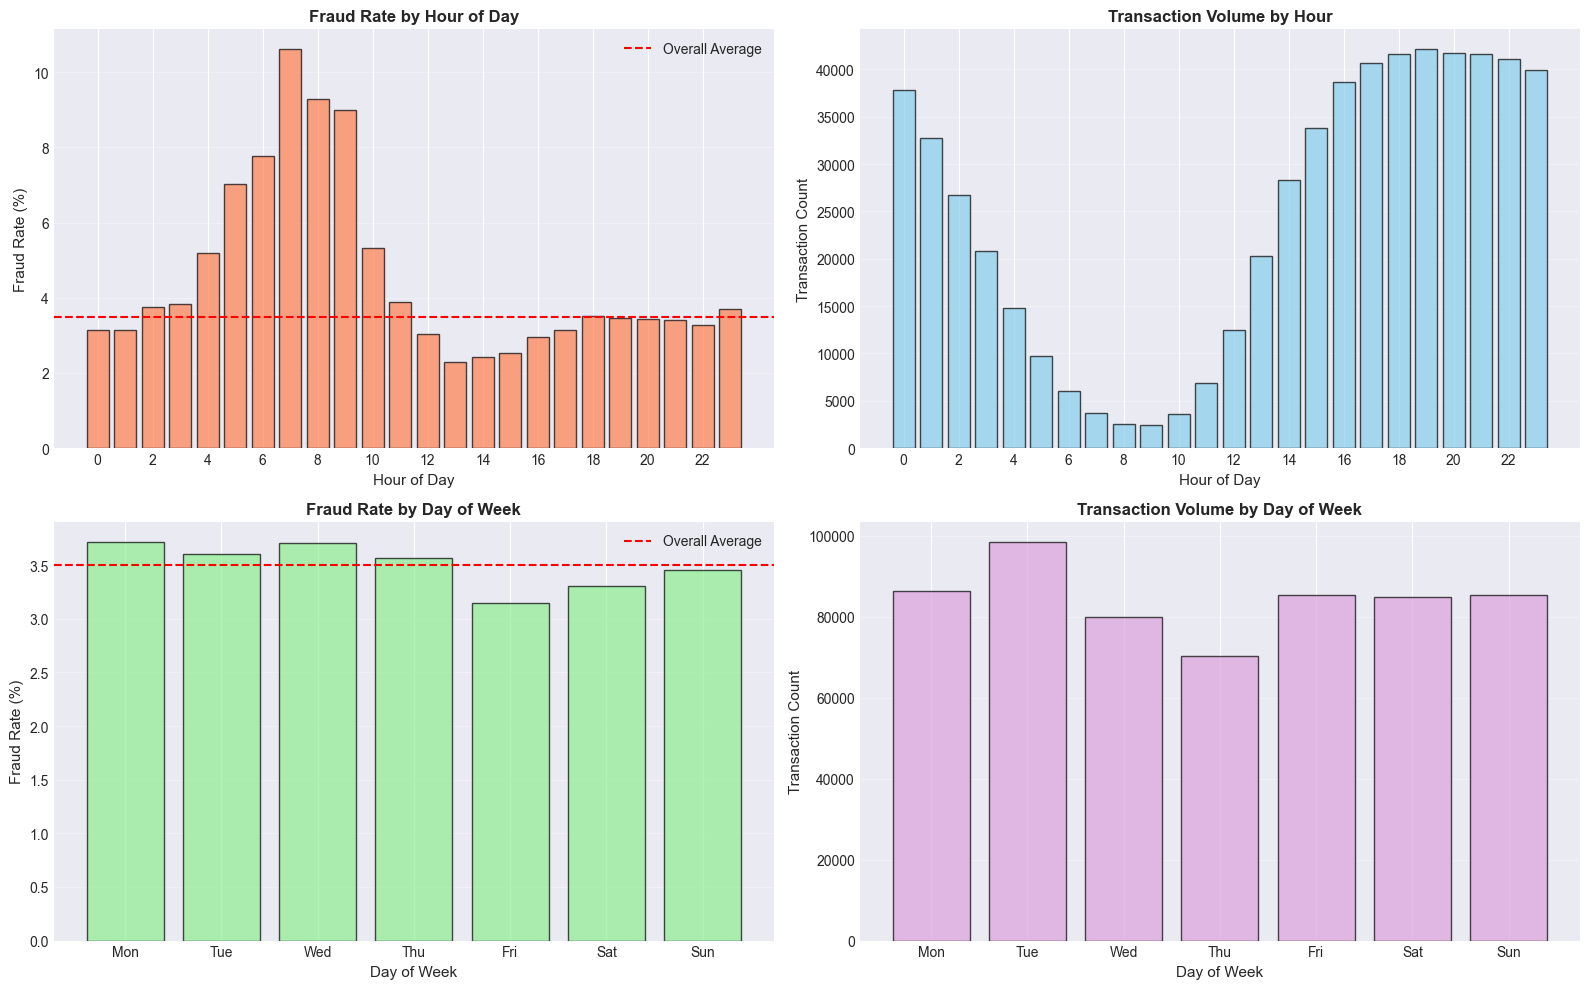

In [10]:
# Visualize hourly and daily patterns
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Fraud rate by hour
ax1 = axes[0, 0]
ax1.bar(fraud_by_hour['Hour'], fraud_by_hour['Fraud_Rate'], 
        color='coral', edgecolor='black', alpha=0.7)
ax1.set_xlabel('Hour of Day', fontsize=11)
ax1.set_ylabel('Fraud Rate (%)', fontsize=11)
ax1.set_title('Fraud Rate by Hour of Day', fontsize=12, fontweight='bold')
ax1.axhline(y=train_with_time['isFraud'].mean()*100, color='red', 
            linestyle='--', label='Overall Average')
ax1.legend()
ax1.set_xticks(range(0, 24, 2))
ax1.grid(True, alpha=0.3, axis='y')

# Transaction volume by hour
ax2 = axes[0, 1]
ax2.bar(fraud_by_hour['Hour'], fraud_by_hour['Total_Count'], 
        color='skyblue', edgecolor='black', alpha=0.7)
ax2.set_xlabel('Hour of Day', fontsize=11)
ax2.set_ylabel('Transaction Count', fontsize=11)
ax2.set_title('Transaction Volume by Hour', fontsize=12, fontweight='bold')
ax2.set_xticks(range(0, 24, 2))
ax2.grid(True, alpha=0.3, axis='y')

# Fraud rate by day of week
ax3 = axes[1, 0]
ax3.bar(fraud_by_dow['Day_Name'], fraud_by_dow['Fraud_Rate'], 
        color='lightgreen', edgecolor='black', alpha=0.7)
ax3.set_xlabel('Day of Week', fontsize=11)
ax3.set_ylabel('Fraud Rate (%)', fontsize=11)
ax3.set_title('Fraud Rate by Day of Week', fontsize=12, fontweight='bold')
ax3.axhline(y=train_with_time['isFraud'].mean()*100, color='red', 
            linestyle='--', label='Overall Average')
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

# Transaction volume by day of week
ax4 = axes[1, 1]
ax4.bar(fraud_by_dow['Day_Name'], fraud_by_dow['Total_Count'], 
        color='plum', edgecolor='black', alpha=0.7)
ax4.set_xlabel('Day of Week', fontsize=11)
ax4.set_ylabel('Transaction Count', fontsize=11)
ax4.set_title('Transaction Volume by Day of Week', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 6. Day Part Analysis

DAY PART ANALYSIS

Fraud rate by part of day:
 Day_Part  Fraud_Count  Total_Count  Fraud_Rate
    Night         5931       148673    3.989292
  Morning         1694        31679    5.347391
Afternoon         5904       203562    2.900345
  Evening         7134       206626    3.452615


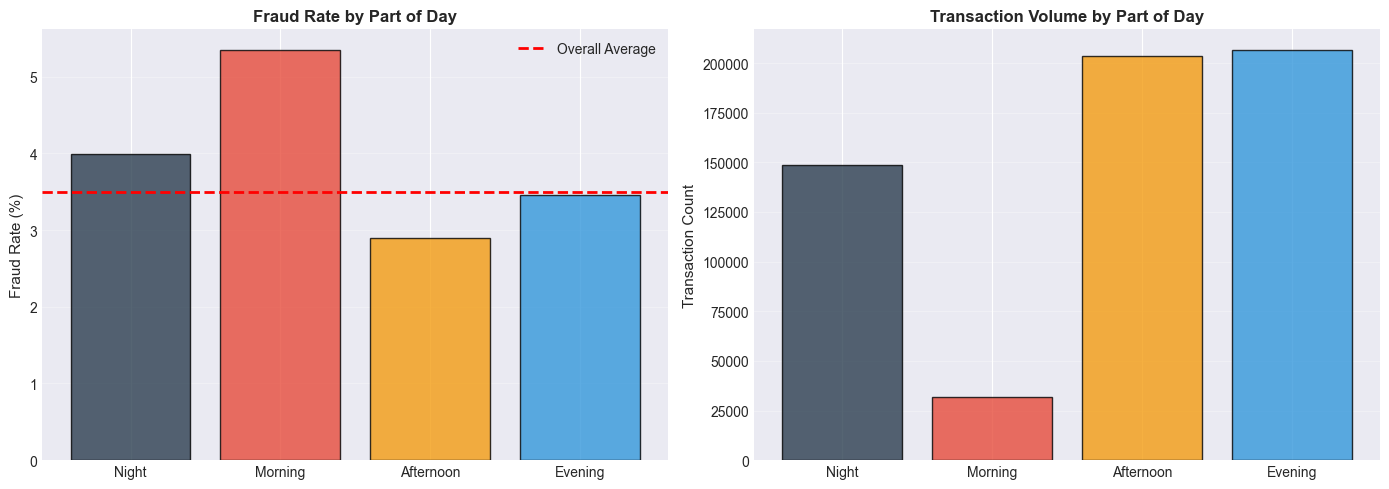

In [11]:
# Analyze fraud rate by part of day
fraud_by_daypart = train_with_time.groupby('DT_day_part').agg({
    'isFraud': ['sum', 'count', 'mean']
}).reset_index()
fraud_by_daypart.columns = ['Day_Part', 'Fraud_Count', 'Total_Count', 'Fraud_Rate']
fraud_by_daypart['Fraud_Rate'] = fraud_by_daypart['Fraud_Rate'] * 100

print("="*60)
print("DAY PART ANALYSIS")
print("="*60)
print("\nFraud rate by part of day:")
print(fraud_by_daypart.to_string(index=False))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]
ax1.bar(fraud_by_daypart['Day_Part'], fraud_by_daypart['Fraud_Rate'], 
        color=['#2c3e50', '#e74c3c', '#f39c12', '#3498db'], edgecolor='black', alpha=0.8)
ax1.set_ylabel('Fraud Rate (%)', fontsize=11)
ax1.set_title('Fraud Rate by Part of Day', fontsize=12, fontweight='bold')
ax1.axhline(y=train_with_time['isFraud'].mean()*100, color='red', 
            linestyle='--', linewidth=2, label='Overall Average')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

ax2 = axes[1]
ax2.bar(fraud_by_daypart['Day_Part'], fraud_by_daypart['Total_Count'], 
        color=['#2c3e50', '#e74c3c', '#f39c12', '#3498db'], edgecolor='black', alpha=0.8)
ax2.set_ylabel('Transaction Count', fontsize=11)
ax2.set_title('Transaction Volume by Part of Day', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 7. Heatmap: Hour vs Day of Week

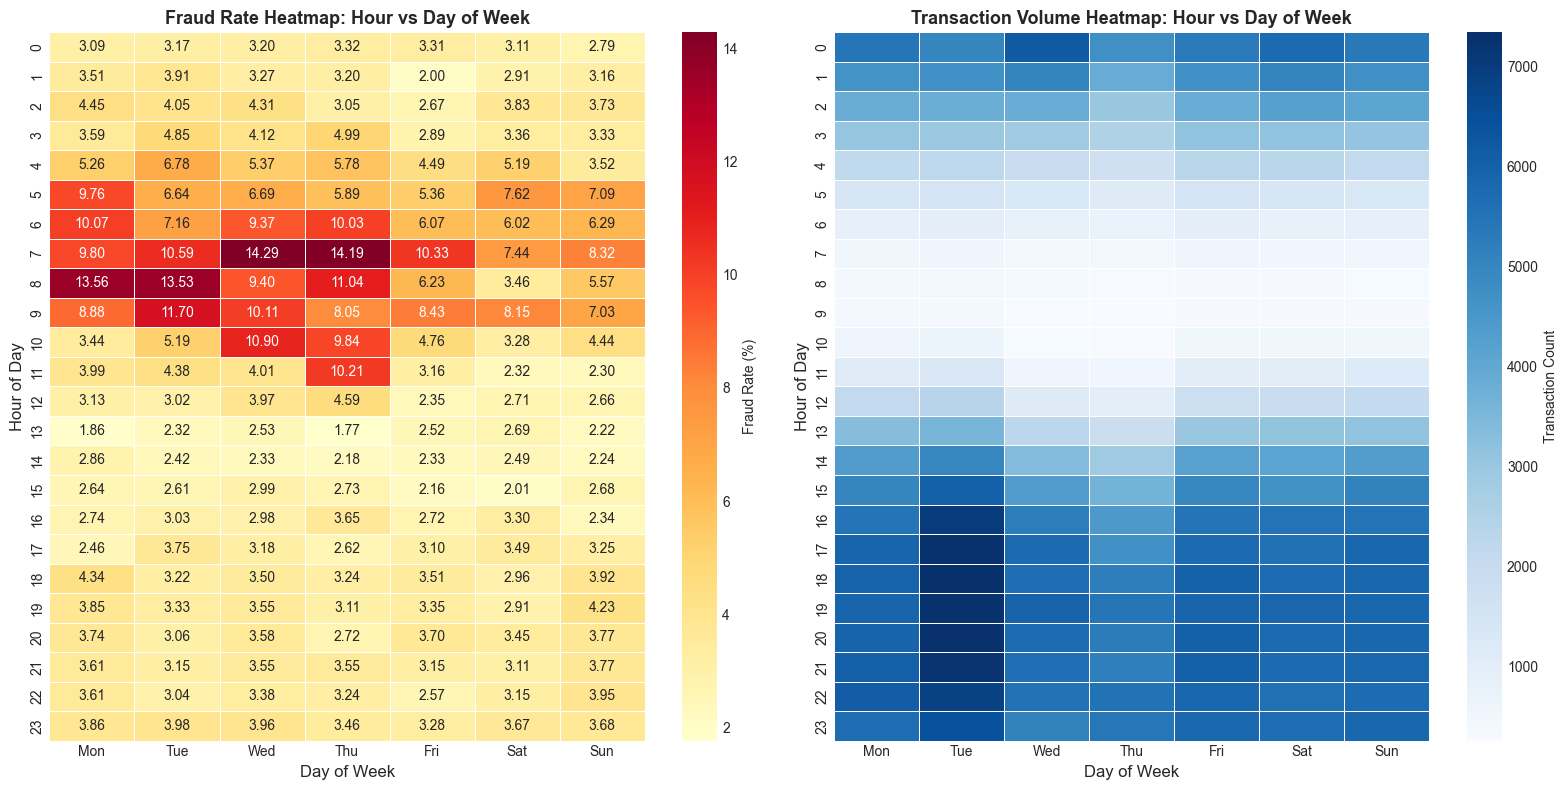


💡 Key patterns to observe:
  - Are there specific hours with consistently higher fraud rates?
  - Do weekends show different patterns than weekdays?
  - Are high-volume periods also high-fraud periods?


In [12]:
# Create hour vs day of week heatmap
fraud_heatmap = train_with_time.groupby(['DT_day_of_week', 'DT_hour'])['isFraud'].mean().reset_index()
fraud_pivot = fraud_heatmap.pivot(index='DT_hour', columns='DT_day_of_week', values='isFraud') * 100

# Transaction count heatmap
count_heatmap = train_with_time.groupby(['DT_day_of_week', 'DT_hour']).size().reset_index(name='count')
count_pivot = count_heatmap.pivot(index='DT_hour', columns='DT_day_of_week', values='count')

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Fraud rate heatmap
ax1 = axes[0]
sns.heatmap(fraud_pivot, annot=True, fmt='.2f', cmap='YlOrRd', 
            cbar_kws={'label': 'Fraud Rate (%)'}, ax=ax1, linewidths=0.5)
ax1.set_xlabel('Day of Week', fontsize=12)
ax1.set_ylabel('Hour of Day', fontsize=12)
ax1.set_title('Fraud Rate Heatmap: Hour vs Day of Week', fontsize=13, fontweight='bold')
ax1.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

# Transaction volume heatmap
ax2 = axes[1]
sns.heatmap(count_pivot, annot=False, cmap='Blues', 
            cbar_kws={'label': 'Transaction Count'}, ax=ax2, linewidths=0.5)
ax2.set_xlabel('Day of Week', fontsize=12)
ax2.set_ylabel('Hour of Day', fontsize=12)
ax2.set_title('Transaction Volume Heatmap: Hour vs Day of Week', fontsize=13, fontweight='bold')
ax2.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

plt.tight_layout()
plt.show()

print("\n💡 Key patterns to observe:")
print("  - Are there specific hours with consistently higher fraud rates?")
print("  - Do weekends show different patterns than weekdays?")
print("  - Are high-volume periods also high-fraud periods?")

## 8. Cross-Validation Strategy Validation

In [13]:
# Validate time-based split strategy
print("="*60)
print("CROSS-VALIDATION STRATEGY")
print("="*60)

print("\n⚠️  Important considerations:")
print("  1. Fraud rate varies over time")
print("  2. Train/test are temporally separated")
print("  3. Standard K-fold would cause data leakage\n")

print("✓ RECOMMENDED: Time-based split")
print("  - Use chronological splits (e.g., train on weeks 1-N, validate on week N+1)")
print("  - Mimics real-world scenario (predict future from past)")
print("  - Prevents temporal leakage\n")

# Demonstrate splits
n_splits = 5
train_with_time_sorted = train_with_time.sort_values('TransactionDT').reset_index(drop=True)
total_size = len(train_with_time_sorted)

print(f"Example: {n_splits}-fold time-based split:")
print(f"Total samples: {total_size:,}\n")

fold_size = total_size // (n_splits + 1)

splits = []
for fold in range(n_splits):
    train_end = (fold + 1) * fold_size
    val_start = train_end
    val_end = val_start + fold_size
    
    train_indices = range(0, train_end)
    val_indices = range(val_start, min(val_end, total_size))
    
    train_fraud_rate = train_with_time_sorted.iloc[train_indices]['isFraud'].mean() * 100
    val_fraud_rate = train_with_time_sorted.iloc[val_indices]['isFraud'].mean() * 100
    
    splits.append({
        'Fold': fold + 1,
        'Train_Size': len(train_indices),
        'Val_Size': len(val_indices),
        'Train_Fraud%': train_fraud_rate,
        'Val_Fraud%': val_fraud_rate
    })
    
    print(f"Fold {fold+1}:")
    print(f"  Train: samples 0 to {train_end:,} (fraud rate: {train_fraud_rate:.2f}%)")
    print(f"  Val:   samples {val_start:,} to {min(val_end, total_size):,} (fraud rate: {val_fraud_rate:.2f}%)")
    print()

splits_df = pd.DataFrame(splits)
print("\nSummary:")
print(splits_df.to_string(index=False))

CROSS-VALIDATION STRATEGY

⚠️  Important considerations:
  1. Fraud rate varies over time
  2. Train/test are temporally separated
  3. Standard K-fold would cause data leakage

✓ RECOMMENDED: Time-based split
  - Use chronological splits (e.g., train on weeks 1-N, validate on week N+1)
  - Mimics real-world scenario (predict future from past)
  - Prevents temporal leakage

Example: 5-fold time-based split:
Total samples: 590,540

Example: 5-fold time-based split:
Total samples: 590,540

Fold 1:
  Train: samples 0 to 98,423 (fraud rate: 2.57%)
  Val:   samples 98,423 to 196,846 (fraud rate: 3.36%)

Fold 2:
  Train: samples 0 to 196,846 (fraud rate: 2.96%)
  Val:   samples 196,846 to 295,269 (fraud rate: 4.12%)

Fold 1:
  Train: samples 0 to 98,423 (fraud rate: 2.57%)
  Val:   samples 98,423 to 196,846 (fraud rate: 3.36%)

Fold 2:
  Train: samples 0 to 196,846 (fraud rate: 2.96%)
  Val:   samples 196,846 to 295,269 (fraud rate: 4.12%)

Fold 3:
  Train: samples 0 to 295,269 (fraud rate: 

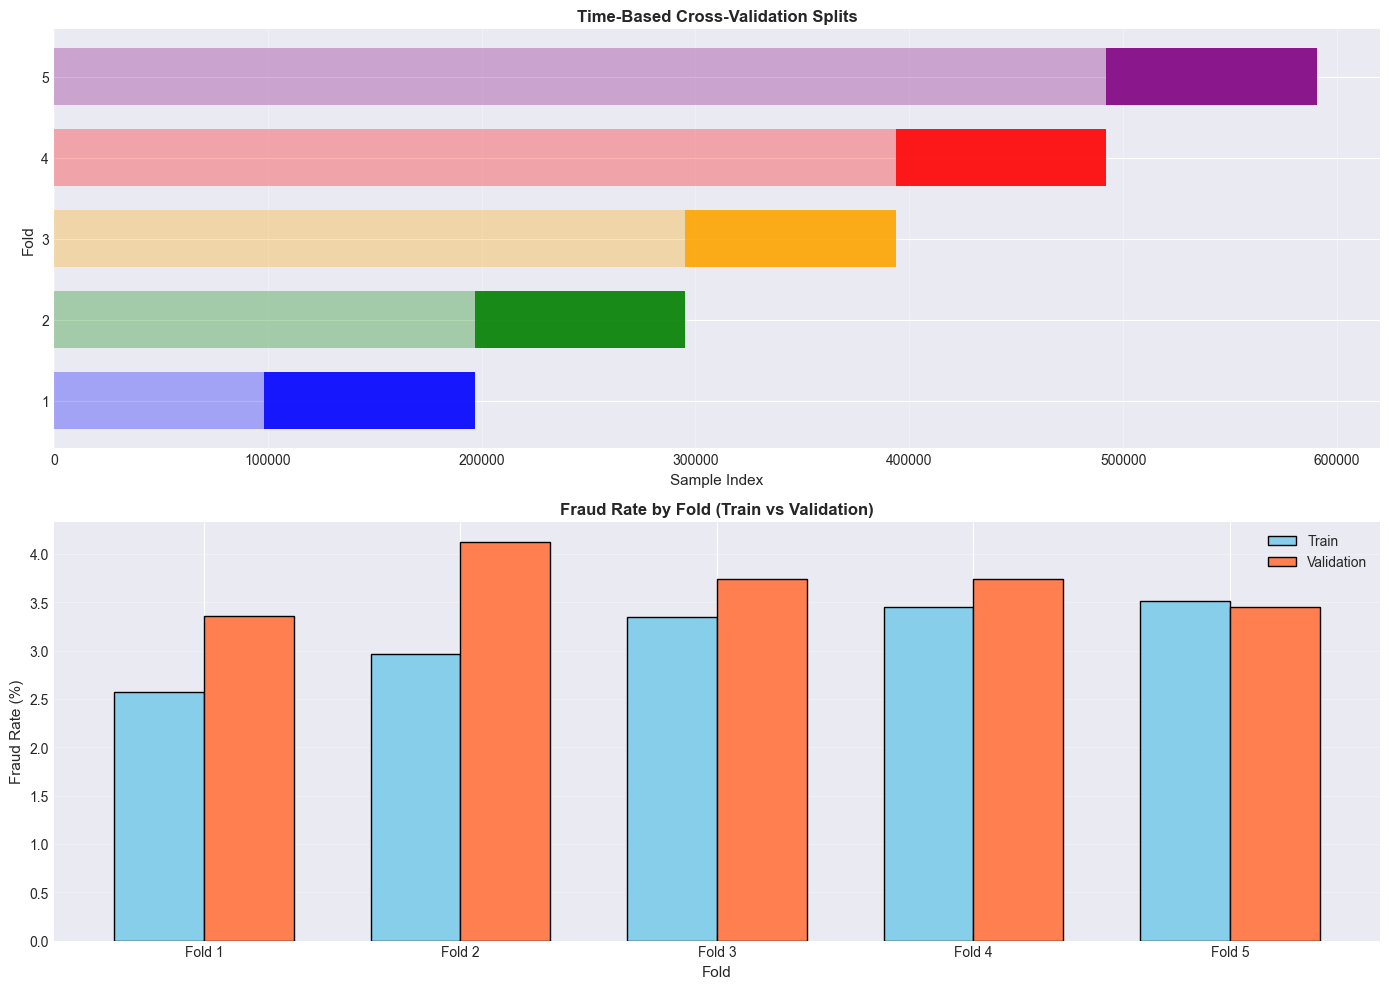


✓ Note how validation fraud rates vary across folds - this reflects real temporal patterns


In [14]:
# Visualize CV splits
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Split visualization
ax1 = axes[0]
colors = ['blue', 'green', 'orange', 'red', 'purple']
for idx, split in enumerate(splits):
    fold = split['Fold']
    train_size = split['Train_Size']
    val_size = split['Val_Size']
    
    # Train
    ax1.barh(fold, train_size, left=0, height=0.7, 
             color=colors[idx], alpha=0.3, label=f'Fold {fold} Train' if idx == 0 else '')
    # Val
    ax1.barh(fold, val_size, left=train_size, height=0.7, 
             color=colors[idx], alpha=0.9, label=f'Fold {fold} Val' if idx == 0 else '')

ax1.set_xlabel('Sample Index', fontsize=11)
ax1.set_ylabel('Fold', fontsize=11)
ax1.set_title('Time-Based Cross-Validation Splits', fontsize=12, fontweight='bold')
ax1.set_yticks(range(1, n_splits + 1))
ax1.grid(True, alpha=0.3, axis='x')

# Fraud rate comparison
ax2 = axes[1]
x = np.arange(len(splits_df))
width = 0.35
ax2.bar(x - width/2, splits_df['Train_Fraud%'], width, label='Train', color='skyblue', edgecolor='black')
ax2.bar(x + width/2, splits_df['Val_Fraud%'], width, label='Validation', color='coral', edgecolor='black')
ax2.set_xlabel('Fold', fontsize=11)
ax2.set_ylabel('Fraud Rate (%)', fontsize=11)
ax2.set_title('Fraud Rate by Fold (Train vs Validation)', fontsize=12, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels([f'Fold {i+1}' for i in range(n_splits)])
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n✓ Note how validation fraud rates vary across folds - this reflects real temporal patterns")

## 9. Transaction Amount vs Time

In [15]:
# Analyze transaction amounts over time
print("="*60)
print("TRANSACTION AMOUNT TEMPORAL PATTERNS")
print("="*60)

# By week
amount_by_week = train_with_time.groupby('DT_week').agg({
    'TransactionAmt': ['mean', 'median', 'std']
}).reset_index()
amount_by_week.columns = ['Week', 'Mean_Amt', 'Median_Amt', 'Std_Amt']

# By fraud status
amount_by_week_fraud = train_with_time.groupby(['DT_week', 'isFraud'])['TransactionAmt'].mean().reset_index()
amount_by_week_fraud.columns = ['Week', 'isFraud', 'Mean_Amt']

print("\nAverage transaction amount by week (first 10 weeks):")
print(amount_by_week.head(10).to_string(index=False))

TRANSACTION AMOUNT TEMPORAL PATTERNS

Average transaction amount by week (first 10 weeks):
 Week   Mean_Amt  Median_Amt    Std_Amt
    0 129.360548      68.950 216.860103
    1 127.708545      68.500 210.614425
    2 131.417521      77.000 194.991195
    3 120.702856      77.000 171.752072
    4 133.615310      67.950 218.935203
    5 135.194687      59.000 230.955351
    6 135.833667      67.950 233.613820
    7 134.527062      59.524 222.193508
    8 141.511923      59.000 269.446221
    9 136.207071      67.950 237.185238

Average transaction amount by week (first 10 weeks):
 Week   Mean_Amt  Median_Amt    Std_Amt
    0 129.360548      68.950 216.860103
    1 127.708545      68.500 210.614425
    2 131.417521      77.000 194.991195
    3 120.702856      77.000 171.752072
    4 133.615310      67.950 218.935203
    5 135.194687      59.000 230.955351
    6 135.833667      67.950 233.613820
    7 134.527062      59.524 222.193508
    8 141.511923      59.000 269.446221
    9 136.20707

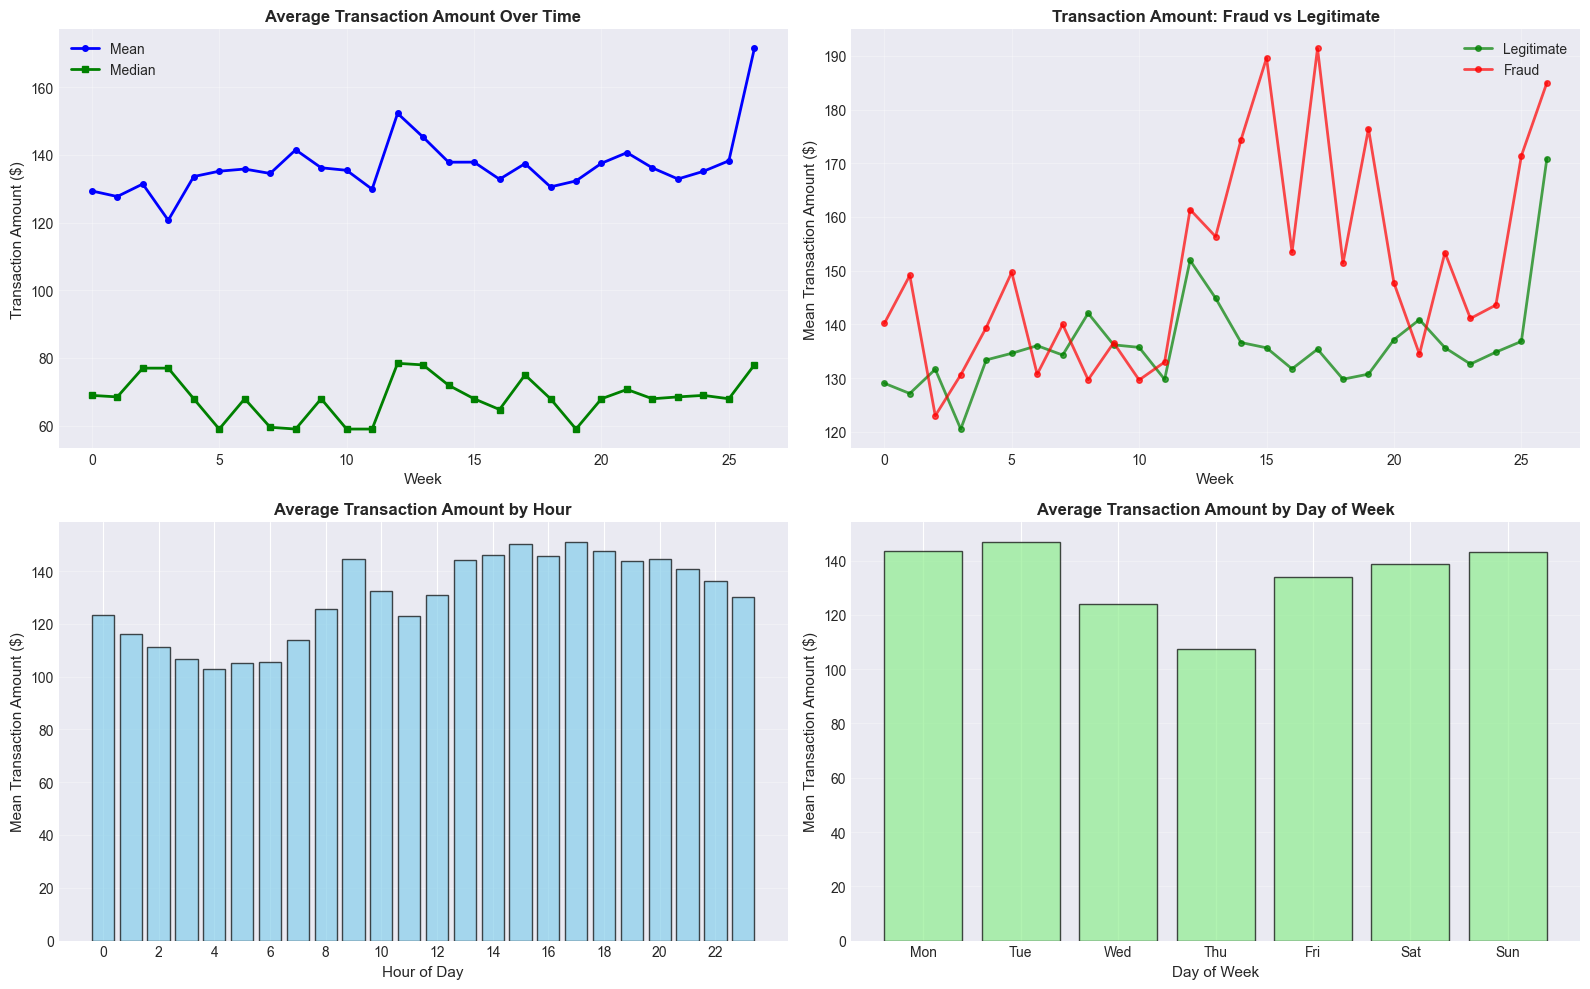

In [16]:
# Visualize transaction amounts over time
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Average amount by week
ax1 = axes[0, 0]
ax1.plot(amount_by_week['Week'], amount_by_week['Mean_Amt'], 
         marker='o', linewidth=2, markersize=4, color='blue', label='Mean')
ax1.plot(amount_by_week['Week'], amount_by_week['Median_Amt'], 
         marker='s', linewidth=2, markersize=4, color='green', label='Median')
ax1.set_xlabel('Week', fontsize=11)
ax1.set_ylabel('Transaction Amount ($)', fontsize=11)
ax1.set_title('Average Transaction Amount Over Time', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Amount by fraud status
ax2 = axes[0, 1]
for fraud_val in [0, 1]:
    data = amount_by_week_fraud[amount_by_week_fraud['isFraud'] == fraud_val]
    label = 'Fraud' if fraud_val == 1 else 'Legitimate'
    color = 'red' if fraud_val == 1 else 'green'
    ax2.plot(data['Week'], data['Mean_Amt'], marker='o', linewidth=2, 
             markersize=4, label=label, color=color, alpha=0.7)
ax2.set_xlabel('Week', fontsize=11)
ax2.set_ylabel('Mean Transaction Amount ($)', fontsize=11)
ax2.set_title('Transaction Amount: Fraud vs Legitimate', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Amount by hour
ax3 = axes[1, 0]
amount_by_hour = train_with_time.groupby('DT_hour')['TransactionAmt'].mean()
ax3.bar(amount_by_hour.index, amount_by_hour.values, 
        color='skyblue', edgecolor='black', alpha=0.7)
ax3.set_xlabel('Hour of Day', fontsize=11)
ax3.set_ylabel('Mean Transaction Amount ($)', fontsize=11)
ax3.set_title('Average Transaction Amount by Hour', fontsize=12, fontweight='bold')
ax3.set_xticks(range(0, 24, 2))
ax3.grid(True, alpha=0.3, axis='y')

# Amount by day of week
ax4 = axes[1, 1]
amount_by_dow = train_with_time.groupby('DT_day_of_week')['TransactionAmt'].mean()
ax4.bar(range(7), amount_by_dow.values, 
        color='lightgreen', edgecolor='black', alpha=0.7)
ax4.set_xlabel('Day of Week', fontsize=11)
ax4.set_ylabel('Mean Transaction Amount ($)', fontsize=11)
ax4.set_title('Average Transaction Amount by Day of Week', fontsize=12, fontweight='bold')
ax4.set_xticks(range(7))
ax4.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 10. Key Insights and Recommendations

In [17]:
# Generate comprehensive temporal insights
print("="*60)
print("KEY TEMPORAL INSIGHTS & RECOMMENDATIONS")
print("="*60)

print("\n📊 TEMPORAL COVERAGE:")
print(f"  • Training period: {train_range/86400:.1f} days ({train_range/604800:.1f} weeks)")
print(f"  • Test period: {test_range/86400:.1f} days ({test_range/604800:.1f} weeks)")
print(f"  • Temporal gap: {(test_start - train_end)/86400:.1f} days")
print(f"  • ✓ No temporal overlap (prevents leakage)")

print("\n⏰ FRAUD RATE TEMPORAL PATTERNS:")
print(f"  • Overall fraud rate: {train_with_time['isFraud'].mean()*100:.2f}%")
print(f"  • Weekly fraud rate range: {fraud_by_week['Fraud_Rate'].min():.2f}% - {fraud_by_week['Fraud_Rate'].max():.2f}%")
print(f"  • Weekly fraud rate std: {fraud_by_week['Fraud_Rate'].std():.2f}%")
print(f"  • Peak fraud hour: {fraud_by_hour.loc[fraud_by_hour['Fraud_Rate'].idxmax(), 'Hour']:.0f}:00 ({fraud_by_hour['Fraud_Rate'].max():.2f}%)")
print(f"  • Lowest fraud hour: {fraud_by_hour.loc[fraud_by_hour['Fraud_Rate'].idxmin(), 'Hour']:.0f}:00 ({fraud_by_hour['Fraud_Rate'].min():.2f}%)")

print("\n🎯 IMPORTANT OBSERVATIONS:")
print("  1. Fraud rate is NOT constant over time")
print("  2. Clear hourly patterns exist (some hours more risky)")
print("  3. Day of week shows variation in fraud rates")
print("  4. Transaction volumes vary by time of day and week")
print("  5. Fraud and legitimate transactions show different temporal patterns")

print("\n✅ RECOMMENDED FEATURES TO CREATE:")
print("  • Hour of day (0-23)")
print("  • Day of week (0-6)")
print("  • Part of day (Night/Morning/Afternoon/Evening)")
print("  • Is weekend (binary)")
print("  • Days since first transaction")
print("  • Weeks since first transaction")
print("  • Transaction velocity (count in last N hours/days)")
print("  • Time since last transaction (by card/email/device)")

print("\n✅ CROSS-VALIDATION STRATEGY:")
print("  ✓ USE: Time-based splits (chronological)")
print("  ✗ AVOID: Random K-fold (causes temporal leakage)")
print("  • Recommendation: 5-fold time-based split")
print("  • Each fold: train on earlier data, validate on later data")
print("  • This mimics production scenario")

print("\n💡 MODELING IMPLICATIONS:")
print("  • Time features will be important predictors")
print("  • Consider separate models for different time periods")
print("  • Monitor for concept drift over time")
print("  • Final model should be validated on most recent data")

print("\n" + "="*60)
print("✓ TEMPORAL ANALYSIS COMPLETED")
print("="*60)
print("\nNext: Data Preprocessing Pipeline (Phase 2)")

KEY TEMPORAL INSIGHTS & RECOMMENDATIONS

📊 TEMPORAL COVERAGE:
  • Training period: 182.0 days (26.0 weeks)
  • Test period: 183.0 days (26.1 weeks)
  • Temporal gap: 207.3 days
  • ✓ No temporal overlap (prevents leakage)

⏰ FRAUD RATE TEMPORAL PATTERNS:
  • Overall fraud rate: 3.50%
  • Weekly fraud rate range: 1.85% - 5.06%
  • Weekly fraud rate std: 0.70%
  • Peak fraud hour: 7:00 (10.61%)
  • Lowest fraud hour: 13:00 (2.29%)

🎯 IMPORTANT OBSERVATIONS:
  1. Fraud rate is NOT constant over time
  2. Clear hourly patterns exist (some hours more risky)
  3. Day of week shows variation in fraud rates
  4. Transaction volumes vary by time of day and week
  5. Fraud and legitimate transactions show different temporal patterns

✅ RECOMMENDED FEATURES TO CREATE:
  • Hour of day (0-23)
  • Day of week (0-6)
  • Part of day (Night/Morning/Afternoon/Evening)
  • Is weekend (binary)
  • Days since first transaction
  • Weeks since first transaction
  • Transaction velocity (count in last N hour

In [18]:
# Save temporal feature engineering function for later use
print("\n📁 Temporal feature engineering function saved for use in preprocessing pipeline.")
print("\nFunction: create_time_features(df)")
print("  Input: DataFrame with 'TransactionDT' column")
print("  Output: DataFrame with additional time-based features")
print("\n✓ Ready to proceed to baseline model development!")


📁 Temporal feature engineering function saved for use in preprocessing pipeline.

Function: create_time_features(df)
  Input: DataFrame with 'TransactionDT' column
  Output: DataFrame with additional time-based features

✓ Ready to proceed to baseline model development!
